In [170]:
import os
import wrf
import math
import cmaps
import datetime
import numpy as np
import netCDF4 as nc
from scipy.interpolate import griddata

In [171]:
def read_decoded_dat(pawr):
    dtype=np.dtype('>f') ### big endian float
    # dtype=np.dtype('<f') ### little endian float

    vread=np.fromfile(pawr,dtype=dtype)

    vlon_radar=vread[1]
    vlat_radar=vread[4]
    vz_radar=vread[7]
    print('==============================')
    print('[pawr radar info]')
    print('radar_site_lon: ',vlon_radar)
    print('radar_site_lat: ',vlat_radar)
    print('radar_site_hgt: ',vz_radar)

    nrec=7     # nrec=8 ### radar-4d
    ioffset=9

    ndata=int((len(vread)-ioffset)/(nrec+2))
    print('radar_data_num: ',ndata)

    vdata=np.zeros(shape=(ndata,nrec))

    for i in range(ndata):
        ista=i*(nrec+2)+1+ioffset
        iend=i*(nrec+2)+nrec+1+ioffset
        vdata[i,:]=vread[ista:iend]

    print('------------------------------')
    print('pawr[*,0] = obs variable')
    print('pawr[*,1] = longitude')
    print('pawr[*,2] = latitude')
    print('pawr[*,3] = altitude')
    print('pawr[*,4] = obs value')
    print('pawr[*,5] = obs error std')
    print('pawr[*,6] = obs type')
    print('==============================')

    return vdata

def read_wrf_latlon(ifile):
 
    ncObj = nc.Dataset(ifile,'r',format='NETCDF3_CLASSIC')

    lat = ncObj.variables['XLAT_M'][:]
    lon = ncObj.variables['XLONG_M'][:]

    ncObj.close()
    return  lat, lon


LEVEL =  [  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000]
[pawr radar info]
radar_site_lon:  139.60898
radar_site_lat:  35.8615
radar_site_hgt:  29.3
radar_data_num:  833616
------------------------------
pawr[*,0] = obs variable
pawr[*,1] = longitude
pawr[*,2] = latitude
pawr[*,3] = altitude
pawr[*,4] = obs value
pawr[*,5] = obs error std
pawr[*,6] = obs type
[0, 33355, 69135, 105346, 141792, 178481, 215321, 252286, 289479, 326970, 364973, 403558, 442750, 482467, 522319, 562498, 602589, 642548, 682287, 721796, 760634, 798134, 833616]
35780


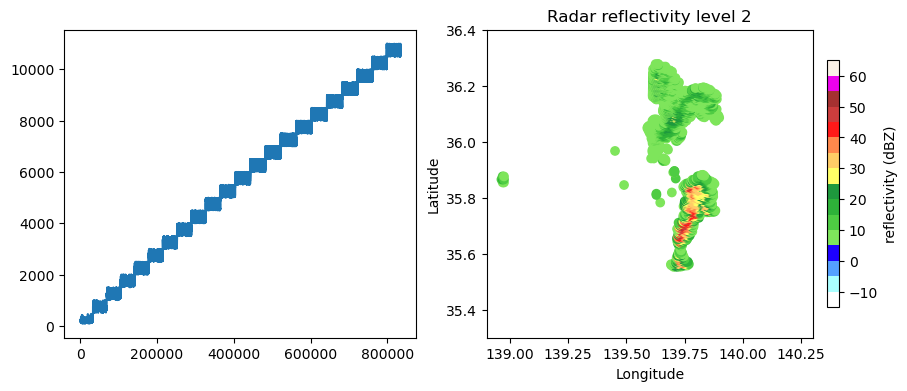

In [172]:
pawr = '/data/ra000007/zhaoyang/postprocess/jp_pawr/data/pawr/radar_20210730060100.dat'
LEVEL = np.arange(500, 11100, 500)
print('LEVEL = ', LEVEL)

# 读取pawr雷达数据
pawr = read_decoded_dat(pawr)
# 将晴空区域反射率设置为0
fillvalue = 0.1
pawr[:,4][pawr[:,4] < 1] = fillvalue
pawr[:,4] = [10 * np.log10(num) for num in pawr[:,4]]
# pawr数据为~500高度间隔自500-11000m, 判断每个高度的数据index
lev_ind = [0]
for i in range(1,len(pawr[:,2])):
    if(pawr[i,2]-pawr[i-1,2]<-0.5):
        lev_ind.append(i)
lev_ind.append(len(pawr[:,2]))
print(lev_ind)


import matplotlib
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(pawr[:,3])


lev = 2
print(lev_ind[lev]-lev_ind[lev-1])
lon_lev = pawr[lev_ind[lev-1]:lev_ind[lev],1]
lat_lev = pawr[lev_ind[lev-1]:lev_ind[lev],2]
val_lev = pawr[lev_ind[lev-1]:lev_ind[lev],4]

lon_lev, lat_lev, val_lev = zip(*((i,j,k) for i,j,k in \
                        zip(lon_lev,lat_lev,val_lev) if (k>5) ))

cmap=cmaps.prcp_1
levels= matplotlib.ticker.MaxNLocator(nbins=16).tick_values(-15,65)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
shadow = ax2.scatter(lon_lev, lat_lev, c=val_lev, cmap=cmap, norm=norm)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_xlim(138.9, 140.3)
ax2.set_ylim(35.3, 36.4)
ax2.set_title('Radar reflectivity level '+str(lev))

cb = plt.colorbar(shadow, fraction=0.035, pad=0.04)
cb.set_label('reflectivity (dBZ)')




(22, 255, 255)
-------------0
data from  0  ~  33355


/tmp/ipykernel_1578308/2399177626.py:56: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon1[0,:,:],lat1[0,:,:],interp_data_new[:,:], cmap=cmap, norm=norm,)


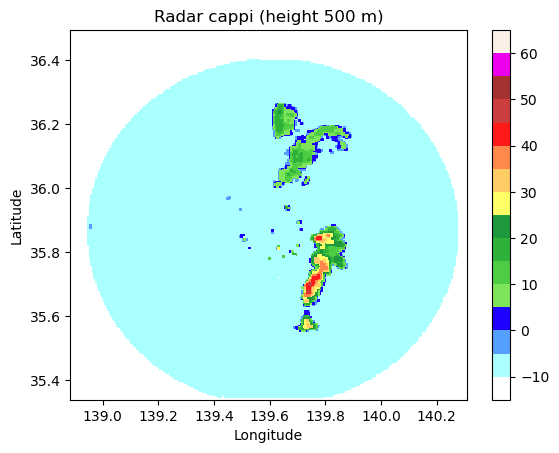

-------------1
data from  33355  ~  69135


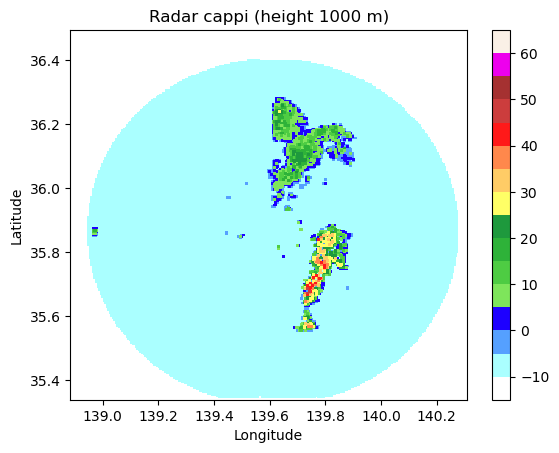

-------------2
data from  69135  ~  105346


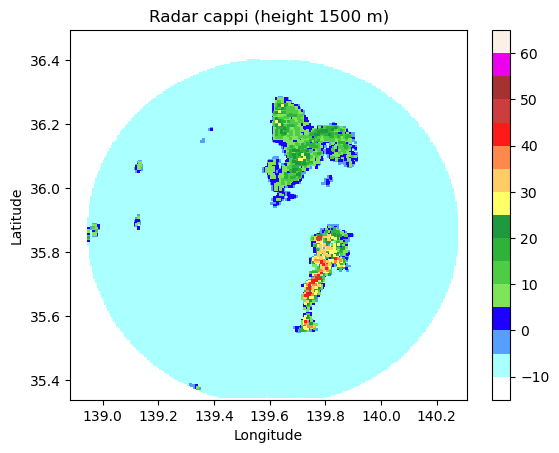

-------------3
data from  105346  ~  141792


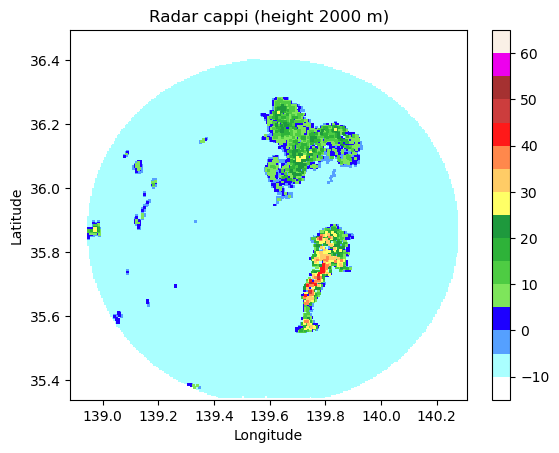

-------------4
data from  141792  ~  178481


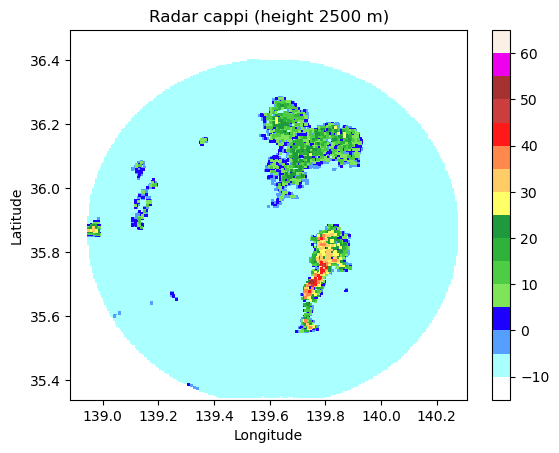

-------------5
data from  178481  ~  215321


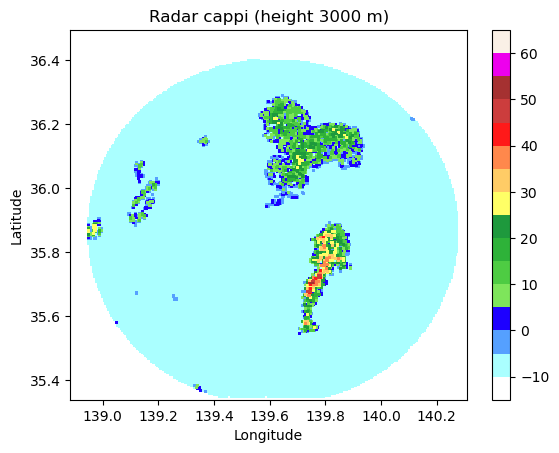

-------------6
data from  215321  ~  252286


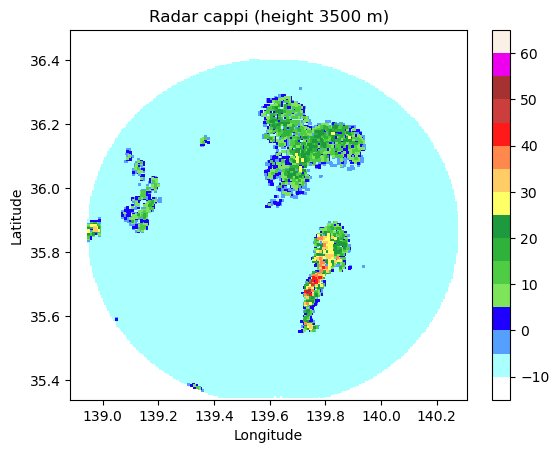

-------------7
data from  252286  ~  289479


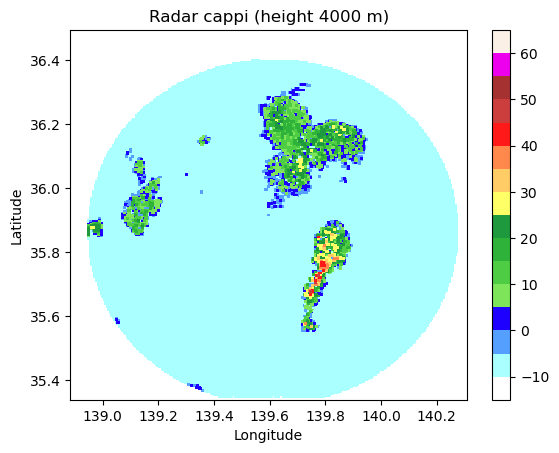

-------------8
data from  289479  ~  326970


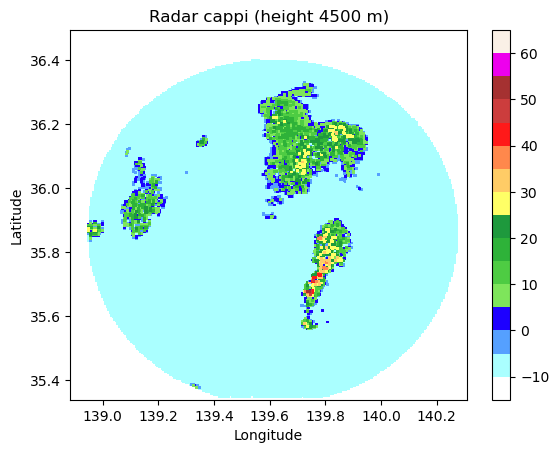

-------------9
data from  326970  ~  364973


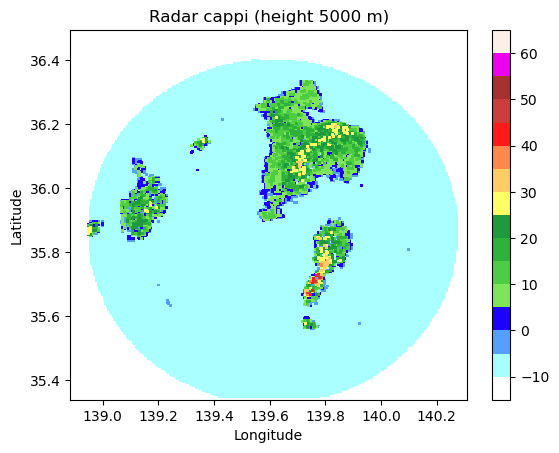

-------------10
data from  364973  ~  403558


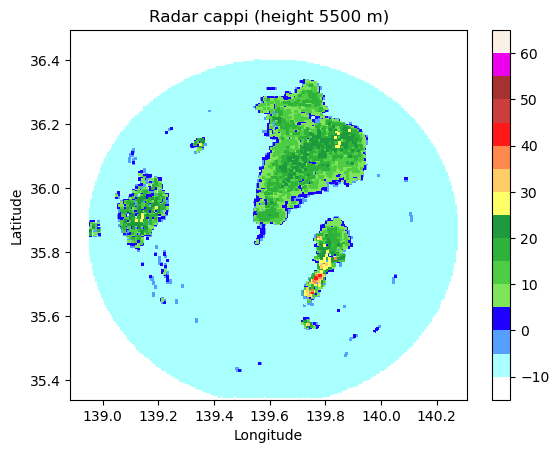

-------------11
data from  403558  ~  442750


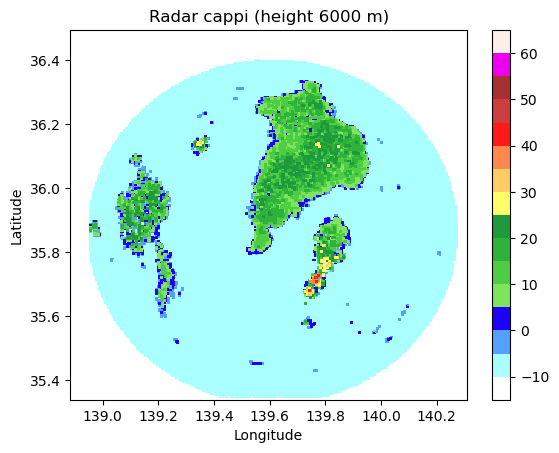

-------------12
data from  442750  ~  482467


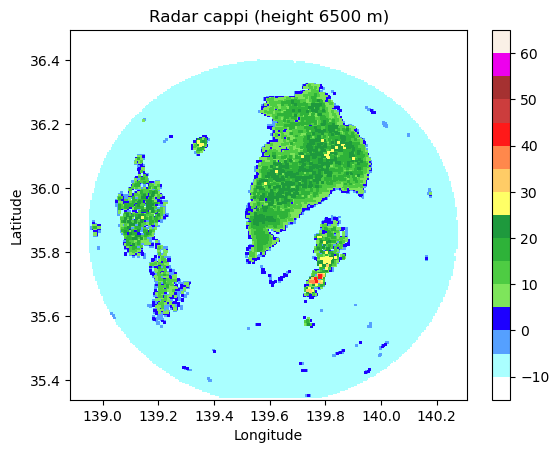

-------------13
data from  482467  ~  522319


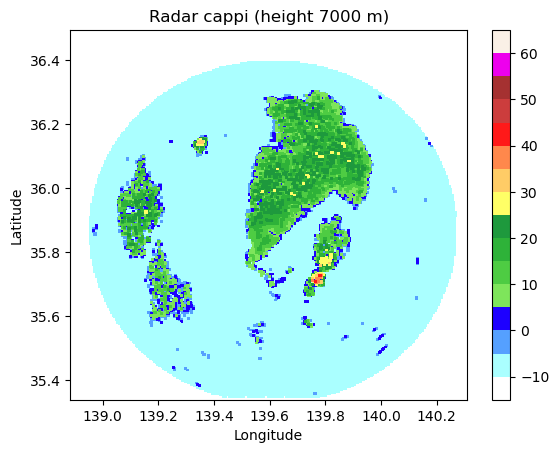

-------------14
data from  522319  ~  562498


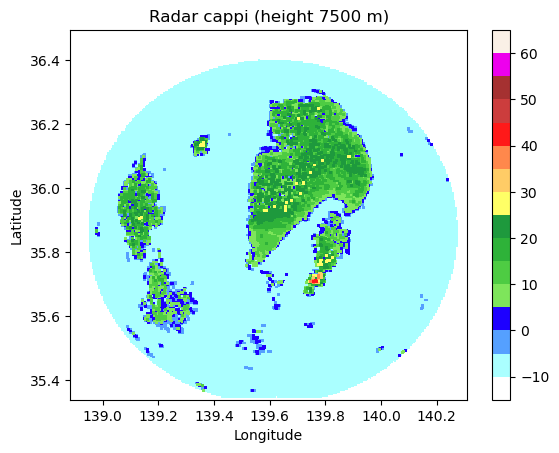

-------------15
data from  562498  ~  602589


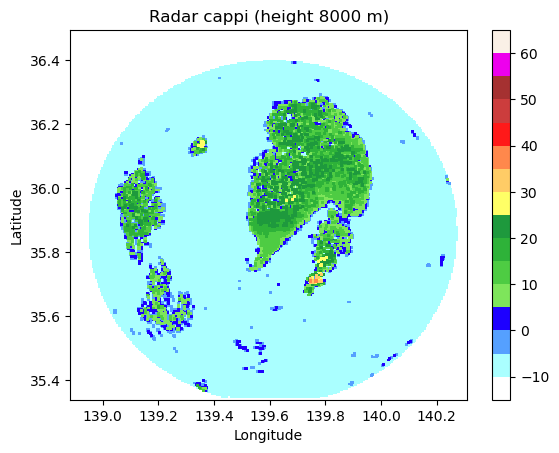

-------------16
data from  602589  ~  642548


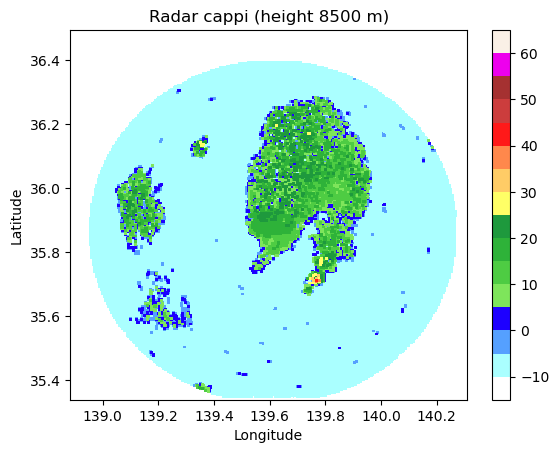

-------------17
data from  642548  ~  682287


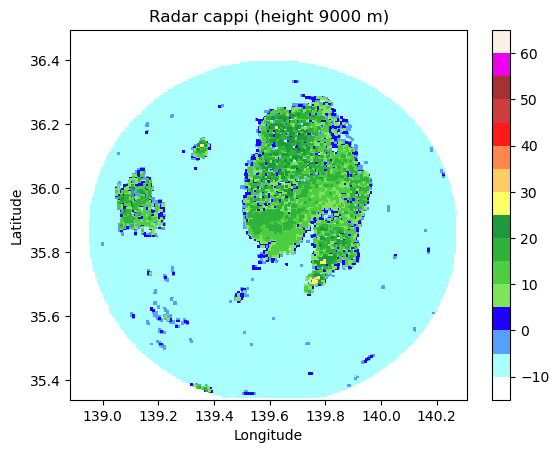

-------------18
data from  682287  ~  721796


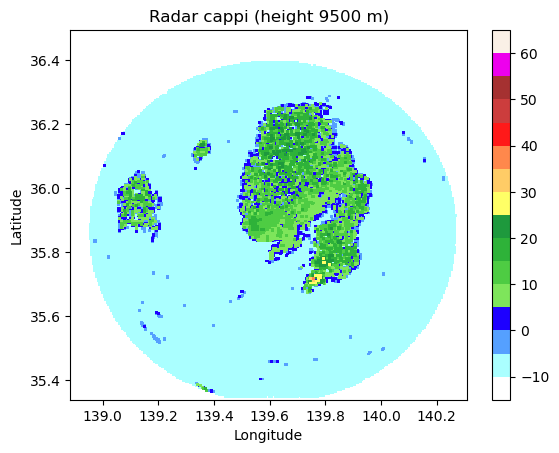

-------------19
data from  721796  ~  760634


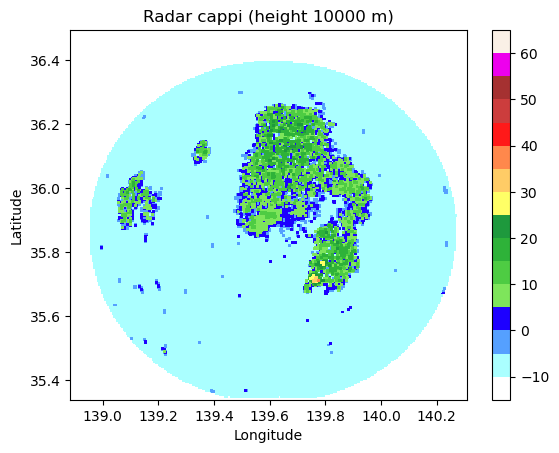

-------------20
data from  760634  ~  798134


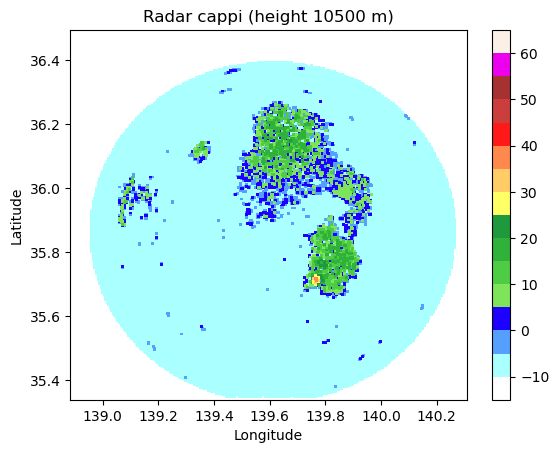

-------------21
data from  798134  ~  833616


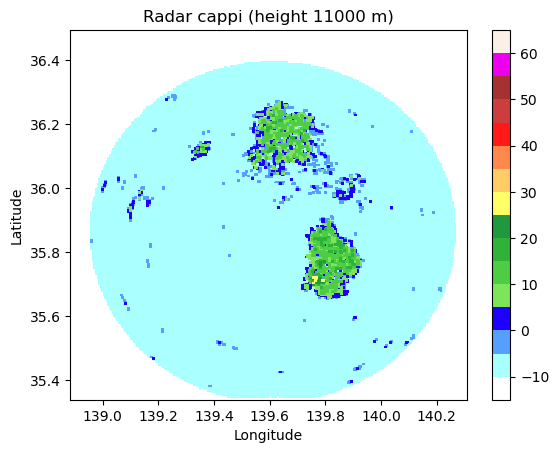

In [173]:
geo = '/data/ra000007/zhaoyang/postprocess/jp_pawr/data/GEJPTK_geogile/geo_em.d04.nc'

# 读取geo文件，提取模式网格
lat1,lon1 = read_wrf_latlon(geo)
nlat = np.shape(lat1)
nlon = np.shape(lon1)
nlev = len(LEVEL)
cappi = np.zeros((nlev, nlat[1], nlat[2]),dtype=float)
print(np.shape(cappi))

interp_mtd = 1

if interp_mtd == 1:
    for il in range(nlev):
        print("-------------" + str(il) )
        cappi_ref=[]
        cappi_ref = np.copy(pawr[lev_ind[il]:lev_ind[il+1],:])
        print('data from ',lev_ind[il],' ~ ',lev_ind[il+1])


        points = np.zeros([len(cappi_ref),2])
        points[:,0]=cappi_ref[:,2]
        points[:,1]=cappi_ref[:,1]

        interp_data_3d = griddata( points, cappi_ref[:,4], (lat1, lon1), method='linear')
        interp_data = np.copy(interp_data_3d[0,:,:])
        
    
        interp_data[ np.isnan(interp_data) ] = -999
        mask = np.where(interp_data < -10, 1, 0)
        mask1 = np.where(interp_data == 1, 1, 0)
        # interp_data[ mask == 1 ] = -999
        interp_data[ mask1 == 1 ] = 0
        interp_data_new = np.copy(interp_data)

        neighbor_index=1
        for i in range(neighbor_index,np.shape(interp_data)[0]-neighbor_index):
            for j in range(neighbor_index,np.shape(interp_data)[1]-neighbor_index):
                # if np.isnan(interp_data_new[i,j]):
                neighbors=[]
                neighbors = np.array(neighbors)
                for ii in range(i-neighbor_index,i+neighbor_index):
                    for jj in range(j-neighbor_index,j+neighbor_index):
                        if (interp_data[ii,jj]>-999):
                            neighbors=np.append(neighbors,interp_data[ii,jj])
                if(len(neighbors)>0):
                    interp_data_new[i,j] = np.max(neighbors)
                    

        # print(interp_data_new[:,170])
        import matplotlib
        import matplotlib.pyplot as plt
        cmap=cmaps.prcp_1
        levels= matplotlib.ticker.MaxNLocator(nbins=16).tick_values(-15,65)
        norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
        plt.pcolormesh(lon1[0,:,:],lat1[0,:,:],interp_data_new[:,:], cmap=cmap, norm=norm,)
        plt.colorbar()#fraction=0.035, pad=0.04)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        # plt.xlim(138.9, 140.3)
        # plt.ylim(35.3, 36.4)
        plt.title('Radar cappi (height '+str(LEVEL[il])+' m)')
        plt.show()



